We will use he same macroeconomics dataset to explore the r/ship btn real disposable income and real consumption. The hypothesis is that as real disposable income increases, so does real consumption. We will use the VAR model to estimate the relationship between real disposable income and real consumption.

Forecasting Real Disposable Income and real consumption

In [2]:
import statsmodels.api as sm 

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


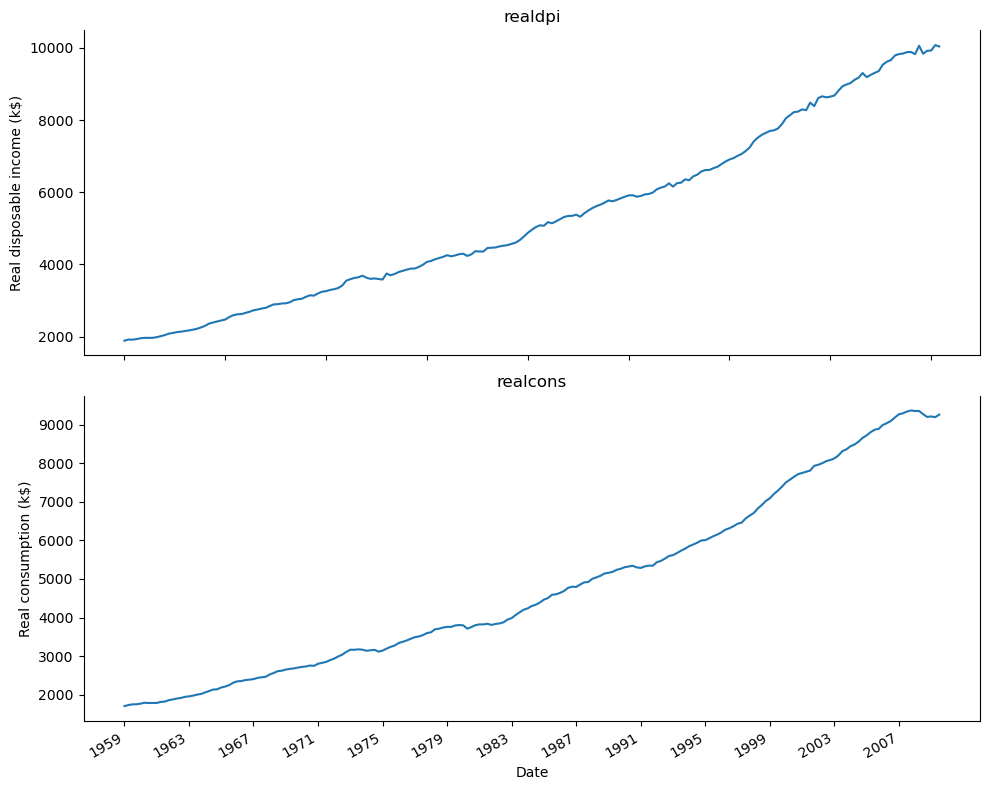

In [5]:
import matplotlib.pyplot as plt
import numpy as np 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [6]:
#test for stationarity of the data 
from statsmodels.tsa.stattools import adfuller
ad_fuller_result1 = adfuller(macro_econ_data['realdpi'])
print('realdpi')
print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')

print('\n----------------------------\n')

ad_fuller_result2 = adfuller(macro_econ_data['realcons'])
print('realcons')
print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')

realdpi
ADF Statistic: 2.986025351954689
p-value: 1.0

----------------------------

realcons
ADF Statistic: 1.5499123380509592
p-value: 0.9976992503412904


Both time series are found not to be stationary. Thus, apply transformations to make them stationary.

In [8]:
ad_fuller_result1 = adfuller(macro_econ_data['realcons'].diff()[1:]) #first-order differencing 

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')

print('\n----------------------------\n')

ad_fuller_result2 = adfuller(macro_econ_data['realcons'].diff()[1:])
print('realcons')
print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')

realdpi
ADF Statistic: -4.204306080845246
p-value: 0.0006479282158627595

----------------------------

realcons
ADF Statistic: -4.204306080845246
p-value: 0.0006479282158627595


In [14]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX
import pandas as pd

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    results = []
    for i in tqdm_notebook(range(15)):  #vary the order p from 0 to 14
        try:
            model = VARMAX(endog, order =(i,0)).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

This function helps us to select the best order (p) for the VAR model. Our training set will be 80% of the data and the test set will be 20% of the data. We need both series to be stationary so we will split the differenced data and feed the differenced training set to the function 

In [15]:
import warnings
warnings.filterwarnings("ignore")

endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:] #1st order differencing to make it stationary as we established above

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)

print(result_df)

  0%|          | 0/15 [00:00<?, ?it/s]

     p          AIC
0    3  3123.070082
1    5  3123.708523
2    6  3126.855595
3    4  3129.194044
4    2  3130.091668
5    7  3133.395666
6    1  3134.333343
7    8  3137.149013
8    9  3140.367183
9   10  3147.838875
10  11  3153.454936
11  12  3157.701978
12  13  3164.096537
13  14  3283.271241


Our data frame returned we see p=3 as the best order for the VAR model(lowest AIC). Meaning that the past 3 values of each time series are used to forecast the other time series. We cannow use the Grange causality test 

Granger Causality test 

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests 
#the function tests if the 2nd var Granger causes the 1st one. We also pass the numbers of lags in a lost which is 3 in our case 

print('realcons Granger-causes realdpi?\n')
print('-----------------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi','realcons']].diff()[1:], [3]) #does realcons Granger-cause realdpi

print('\nrealdpi Granger-causes realcons?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])  #test if realdpi Granger-causes realcons 



realcons Granger-causes realdpi?

-----------------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

-------------------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


Running the Granger causality test for both variables returns a p-value smaller than
0.05 in both cases. Therefore, we can reject the null hypothesis and conclude that
realdpi Granger-causes realcons, and realcons Granger-causes realdpi. Our
VAR(3) model is thus valid.

Residual Analysis

In [20]:
best_model = VARMAX(train, order =(3,0)).fit(disp=False)

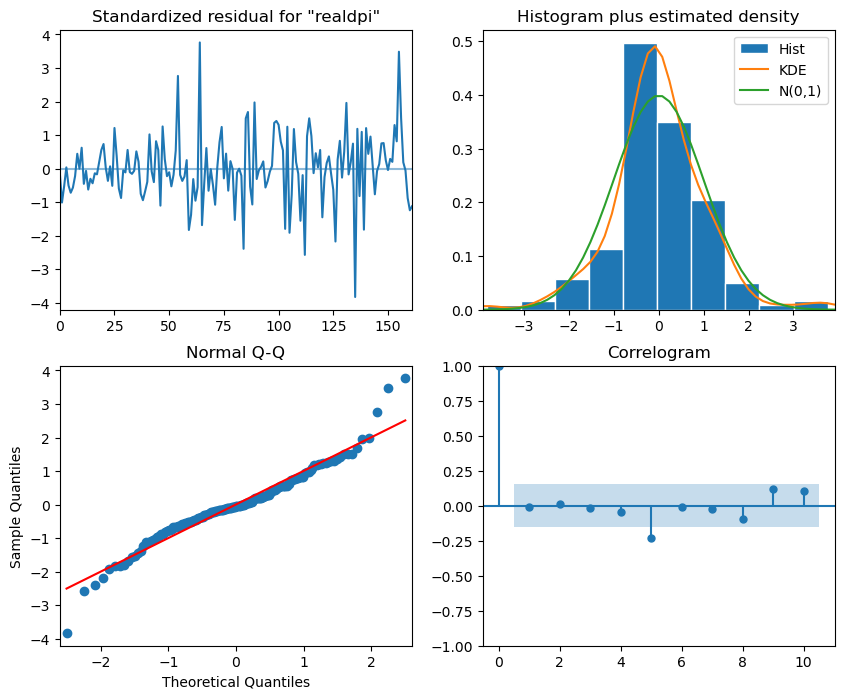

In [21]:
best_model.plot_diagnostics(figsize=(10,8), variable =0) #this specifies that we want residuals of realdpi bc it was the first to be first passed to the VAR model 

plt.show()

The correlogram shows no significant coefficients except at lag 5. However, this is likely due to chance, since there are no
preceding significant coefficients.

The Q-Q plot is a failry straight line.

The histogram closely resembles the shape of a normal distribution 

The standardzed residuals in frame one seem to show no trend and constant variance which is line with white noise distribution. We can conclude that the residuals are close to white noise

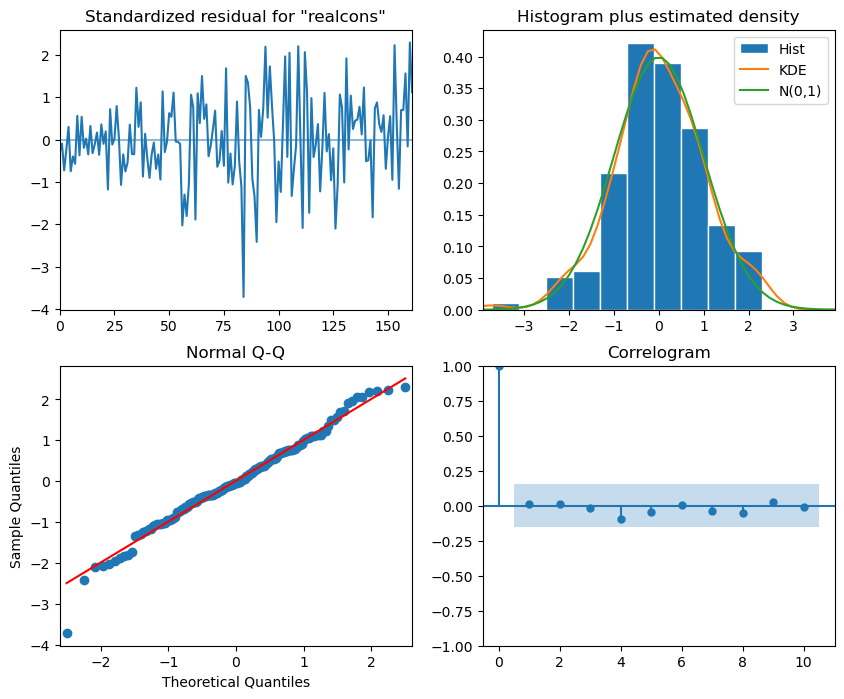

In [23]:
#Residual analyis of realcons

best_model.plot_diagnostics(figsize=(10,8), variable =1)
 #this specifies that we want residuals of realcons bc it was the second to be first passed to the VAR model

plt.show()

Quantitative analysis of residuals

Null hypothesis of the Ljung-Box test states that the residuals are independent and uncorrelated with each other.

Thus for the residuals to behave like white noise, the test must return p-values that are greater than 0.05

In [26]:
#import ljung box test

from statsmodels.stats.diagnostic import acorr_ljungbox
realgdp_resid = best_model.resid['realdpi']

acorr_ljungbox(realgdp_resid, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.011641,0.914078
2,0.029400,0.985408
3,0.075829,0.994571
4,0.377929,0.984244
5,9.142497,0.103514
6,9.165332,0.164491
7,9.270079,0.233843
8,10.811512,0.212610
9,13.318051,0.148735
10,15.287303,0.121933


In [27]:
realcons_resid = best_model.resid['realcons']

acorr_ljungbox(realcons_resid, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.023877,0.877199
2,0.068715,0.966226
3,0.068792,0.995299
4,0.235719,0.993577
5,0.377772,0.995920
6,0.787312,0.992410
7,1.015247,0.994579
8,2.150382,0.976051
9,2.437078,0.982528
10,2.442743,0.991684


Forecasting realcons and realdp using the VAR model by performing a rolling forecasting

We’ll forecast four steps into the future(window), which is equivalent to forecasting one
full year as the data is sampled quarterly. We’ll thus perform a rolling forecast four
steps into the future over the entire length of the test set

In [33]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = [] #Init an empty list to store predictions
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1) #iterate predicitons over the next 4 windows 
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi'] #extract predicitions for realdpi
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi) #append the predictions to the list
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR 
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons'] #extract last value of realdpi and realcons
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last



In [34]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')
#we use endog_diff because VAR(3) requires our data to be stationary so we have used the differenced data

In [35]:
# we must thus apply the inverse differencing by integrating the forecasts using cumulative sum 
test = endog[163:].copy()

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)


test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test 

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.222186,7354.322994
164,8053.4,7501.3,7897.185023,7430.252053
165,8135.9,7571.8,7960.558315,7496.624960
166,8222.3,7645.9,8014.750371,7556.608949
167,8234.6,7713.5,8080.699041,7630.993747
168,8296.5,7744.3,8142.391756,7692.844861
169,8273.7,7773.5,8200.126019,7753.867491
170,8484.5,7807.7,8259.368313,7812.539131
171,8385.5,7930.0,8264.392293,7864.639721
172,8611.6,7957.3,8320.864619,7895.064458


In [36]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.222186,7354.322994,7716.0,7199.9
164,8053.4,7501.3,7897.185023,7430.252053,7716.0,7199.9
165,8135.9,7571.8,7960.558315,7496.624960,7716.0,7199.9
166,8222.3,7645.9,8014.750371,7556.608949,7716.0,7199.9
167,8234.6,7713.5,8080.699041,7630.993747,8135.9,7571.8
168,8296.5,7744.3,8142.391756,7692.844861,8135.9,7571.8
169,8273.7,7773.5,8200.126019,7753.867491,8135.9,7571.8
170,8484.5,7807.7,8259.368313,7812.539131,8135.9,7571.8
171,8385.5,7930.0,8264.392293,7864.639721,8273.7,7773.5
172,8611.6,7957.3,8320.864619,7895.064458,8273.7,7773.5


Now test holds the actual values of the test set, the predictions from the VAR(3)
model, and the predictions from the baseline method. Everything is set for us to visualize
the forecasts and evaluate the forecasting methods using the mean absolute percentage
error (MAPE).

In [39]:
def mape (y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100 

mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_real_cons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_real_cons_last = mape(test['realcons'], test['realcons_pred_last'])

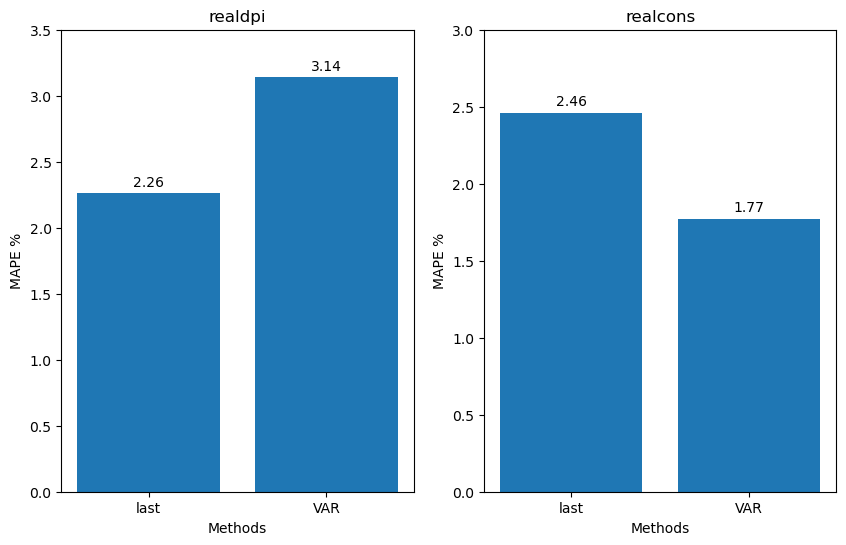

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']

y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_real_cons_last, mape_real_cons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE %')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x, y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE %')
ax2.set_title('realcons')
ax2.set_ylim(0,3)

for index, value in enumerate (y1):
    ax1.text(x=index, y=value+0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate (y2):
    ax2.text(x=index, y=value+0.05, s=str(round(value,2)), ha='center')


plt.show()

We can see that the VAR(3) model performs worse than the baseline in
the case of realdpi but better than the baseline for realcons. This is an ambiguous
situation. There is no clear result, since the model does not outperform the baseline
in both situations.
We can hypothesize that in the case of realdpi, realcons is not predictive enough
to make more accurate forecasts than the baseline, even though the Granger causality
test passed. Therefore, we should resort to using a variation of the SARIMAX model to
predict realdpi. Thus, we can conclude that the VAR(3) model is not sufficient to
accurately forecast realdpi and realcons. I would suggest using two separate models,
which could include realdpi and realcons as exogenous variables, while also potentially
including moving average terms.